Package import

In [19]:
import rioxarray
from rioxarray.merge import merge_arrays
import xarray
from rasterio.features import shapes, geometry_mask
from shapely import geometry
from shapely.geometry import shape, mapping, MultiPolygon
from rasterio.mask import mask
import rasterio
import numpy as np

Specify data source

In [2]:
filepath = '/Users/eslt0101/Data/eScience/IceShelves/TestDataSet/S2_comp_first.tif'


load file as xarray.DataArray

In [3]:
bands = rioxarray.open_rasterio(filepath)

inspect DataArray object

In [4]:
bands


<xarray.DataArray (band: 3, y: 10002, x: 10004)>
[300180024 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1 2 3
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first')
    grid_mapping:  spatial_ref

bounds and crs of DataArray

In [5]:
bands.rio.bounds()


(-1653920.0, -366670.0, -1553880.0, -266650.0)

In [6]:
bands.rio.crs

CRS.from_epsg(3031)

Define toy polygons for testing. 2 Square boxes. Defined usiing shapely

In [7]:
p1=geometry.Point([-1601000.0, -300000.0])
p2=geometry.Point([-1601000.0, -280000.0])
p3=geometry.Point([-1580000.0, -280000.0])
p4=geometry.Point([-1580000.0, -300000.0])
plist1 = [p1,p2,p3,p4]

p5=geometry.Point([-1651000.0, -360000.0])
p6=geometry.Point([-1651000.0, -350000.0])
p7=geometry.Point([-1640000.0, -350000.0])
p8=geometry.Point([-1640000.0, -360000.0])
plist2 = [p5,p6,p7,p8]

In [8]:
poly1 = geometry.Polygon([[p.x,p.y] for p in plist1])
poly2 = geometry.Polygon([[p.x,p.y] for p in plist2])

In [9]:
type(poly1)

shapely.geometry.polygon.Polygon

Convert to georegistered polygons and group together

In [10]:
from geopandas import GeoSeries

In [11]:
polys = GeoSeries([poly1,poly2],crs=bands.spatial_ref.crs_wkt)

In [12]:
polys

0    POLYGON ((-1601000.000 -300000.000, -1601000.0...
1    POLYGON ((-1651000.000 -360000.000, -1651000.0...
dtype: geometry

In [ ]:
#import json
#from shapely.wkt import loads
#import shapely.geometry as geometry


create mask based on geometry. Invert mask to select pixels WITHIN bounds. ATTENTION possible to select on touch or center inclusion

In [13]:
mmask = geometry_mask(polys,out_shape=(len(bands.y),len(bands.x)),transform=bands.rio.transform(),invert=True)


Inspect data type of mask -> ndarray

In [15]:
mmask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [16]:
mmask.shape


(10002, 10004)

mask is boolean. Convert to integer representation true==1 false==0

define helper conversion function

In [22]:
def boolstr_to_intstr(v):
    if v == 'True':
        return '1'
    elif v == 'False':
        return '0'
    else:
        return v
    

In [23]:
m2mask = np.vectorize(boolstr_to_intstr)(mmask).astype(np.dtype('uint16'))

convert mask to DataArray. import coordinates from bands 

In [24]:
amask= xarray.DataArray(data=m2mask,dims=['y','x'],coords={'y':bands[0].coords['y'],'x':bands[0].coords['x']})

In [25]:
amask

<xarray.DataArray (y: 10002, x: 10004)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
  * y        (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x        (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06

Add attributes and projection, crs from bands object

In [26]:
from rioxarray.rioxarray import _add_attrs_proj

In [28]:
import matplotlib.pyplot as plt

In [29]:
from matplotlib.pyplot import imshow

inspect mask

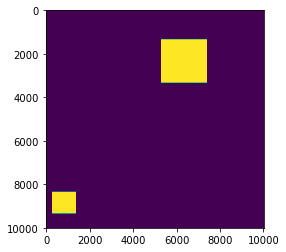

In [30]:
imshow(amask)

In [31]:
print(bands.rio.nodata)

None


In [32]:
print(amask.rio.nodata)

None


In [33]:
_add_attrs_proj(amask,bands[0])

<xarray.DataArray (y: 10002, x: 10004)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
  * y            (y) float64 -2.667e+05 -2.667e+05 ... -3.667e+05 -3.667e+05
  * x            (x) float64 -1.654e+06 -1.654e+06 ... -1.554e+06 -1.554e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_first', 'B3_first', 'B2_first')
    grid_mapping:  spatial_ref

In [ ]:
amask.rio.set_crs(bands[0].rio.crs)

In [ ]:
amask.rio.crs

In [ ]:
bb=bands[0]

In [ ]:
bb.size

In [ ]:
import numpy as np

In [ ]:
cc=np.array([[1,2],[3,4]])

In [ ]:
type(cc)

In [ ]:
bands[0]

In [ ]:
amask

In [ ]:
bb.rio.y_dim

In [ ]:
out=merge_arrays([bands[0],amask])

In [ ]:
bmask = mmask.copy()

In [ ]:
type(bmask)

In [ ]:
print(0.05*1.e6)

